In [11]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from bs4 import BeautifulSoup
import requests
import random
import pickle
import re
import spacy
nlp = spacy.load('en_core_web_trf')
from spacy import displacy
import collections
from collections import Counter
from tqdm.notebook import tqdm as tqdm_notebook
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from transformers import DistilBertTokenizer, DistilBertModel, logging
from matplotlib.figure import Figure
from matplotlib import cm
import matplotlib.colors as colors
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

logging.set_verbosity_error()

In [2]:
import sys
sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

import predict_model
from build_features import text_cleaner
%matplotlib inline

In [3]:
# URL
URL = 'https://en.wikipedia.org/wiki/Glossary_of_plant_morphology'
# Get the page
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, "lxml", from_encoding="iso-8859-1")   

glossary = collections.defaultdict(list)
# Find all H4 
for chapter in soup.find_all('h4')[0:]:
    # Clean
    chapter_text = chapter.text.rstrip('[edit]')
    # Find all siblings
    for sibling in chapter.find_next_siblings():
        # Find the parent
        for parent in sibling.find_previous_sibling('h4'):
            # Only append if correspond to current chapter
            if parent.text == chapter_text:
                if 'â' in sibling.text:
                    for tag in sibling.find_all('li'):
                        candidates = tag.text.split('â')[0]
                        candidates = candidates.split('/')
                        for candidate in candidates:
                            glossary[chapter_text.lower()].append(candidate.strip().lower())  
                            

In [4]:
glossary['leaves'] += [
    'glume', 'surface', 'margin',
    'leaves', 'auricles', 'spatheole',
    'ovate', 'lanceolate',
]

glossary['basic flower parts'] += [
    'floret', 'awn',
    'pod', 'lobe',
    
]
glossary['inflorescences'] += [
    'spikelets', 'lemma', 'racemes',
    'axis',
]
glossary['leaves'] += [
    'rhachilla',
    'needles',
]

glossary['other parts'] += [
    'apex', 'culm', 'tube',
    'palea', 'crown', 'canopy',
    'base', 'callus', 'hair',
    'anther', 'tuberculate'

]

glossary['plant property'] += [
    'tree', 'shrub',
    'life-span', 'life', 'span',
    'bloom-time',
]

In [5]:
with open('../data/glossaries/plants.pkl', 'wb') as f:
    pickle.dump(glossary, f)      

In [6]:
compounds = [
    'fertile', 'sterile',
    'male', 'female', 'bisexual',
    'basal', 'developed', 
    'primary', 'secondary', 'main',
    'upper', 'lower', 'greater', 'dorsal', 'alternate', 'lesser', 'apex', 'outer',
    'central', 'outermost', 'outer', 'inner', 'uppermost', 'median', 'dorsal', 'central', 'lateral',
    'young', 'mature',
]

rubbish = [
    '.', ',', '-',
]


#with open('../../data/glossaries/plants_compounds.pkl', 'wb') as f:
#    pickle.dump(compounds, f)     

In [7]:
def compound_reconstructor(token, doc):
    if token.i == 0:
        trait = token
    elif doc[token.i - 1].pos_ == 'DET':
        trait = token
    elif doc[token.i - 3].dep_ == 'compound':
        trait = doc[token.i - 3: token.i + 1]
    elif doc[token.i - 3].text.lower() in compounds or doc[token.i - 3].lemma_.lower() in compounds:
        trait = doc[token.i - 3: token.i + 1]
    elif doc[token.i - 2].dep_ == 'compound':
        trait = doc[token.i - 2: token.i + 1]
    elif doc[token.i - 2].text.lower() in compounds or doc[token.i - 3].lemma_.lower() in compounds:
        trait = doc[token.i - 2: token.i + 1]
    elif doc[token.i - 1].dep_ == 'compound':
        trait = doc[token.i - 1: token.i + 1]
    elif doc[token.i - 1].text.lower() in compounds or doc[token.i - 3].lemma_.lower() in compounds:
        trait = doc[token.i - 1: token.i + 1]
    else:
        trait = token
    if ','  in trait.lemma_:
        return None
    return trait.lemma_

def check_existance(t, doc):
    
    # Check prep
    single = next((key for key, value in glossary.items() if t.lemma_.lower() in value), None)
    multi = next((key for key, value in glossary.items() if t.text.lower() in value), None)
    if single:
        return single
    elif multi:
        return multi
    else:
        return None


def verbal_helper(t, doc, attribute):
    """HELPER"""
    for child in t.children:
        if child.dep_ == attribute:
            obj = doc[child.left_edge.i : child.right_edge.i + 1]
            return obj 
        
def clean_verbs(relations, objects):
    rel = []
    obj = []
    for relation, object_ in zip(relations, objects):       
        for obj_split in re.split(',|and', object_):
            rel.append(relation.lower().strip())
            obj.append(obj_split.lower().strip())            
            
    return rel, obj


def clean_nouns(objects_dirty):
    
    
    objects = []
    for object_dirty in objects_dirty:
        split_objects = re.split(',|and', object_dirty)
        if len(split_objects) == 1:
            objects.append(split_objects[0].strip())
        elif len(split_objects) == 2:
            objects.append(split_objects[0].strip())
            objects.append(split_objects[1].strip())
        else:
            objects.append(split_objects[0].strip())
            objects.append(split_objects[1].strip())
    return objects
        
def extract_verbal_information(t, doc):
    
    attributes = ["attr", "prep", "pobj", 
                  "oprd", "agnt", "nmod", 
                  "advm", "acomp", "pcomp",
                  "acl"]
    
    allowed_items = ['ROOT', 'nsubj', 'nsubjpass', 
                     'csubj', 'csubjpass']
    
    relations = []
    objects   = []
        
    if t.dep_ in allowed_items:
        parent = next((parent for parent in t.ancestors), None)
        if parent and parent.pos_ == 'VERB' or parent and parent.pos_ == 'AUX':
            for attribute in attributes:
                item = verbal_helper(parent, doc, attribute)
                if item:
                    relations.append(parent.text), 
                    objects.append(item.text)
        else:
            for child in t.children:
                if child.pos_ == 'VERB' and child.dep_ != 'amod':
                    for attribute in attributes:
                        item = verbal_helper(child, doc, attribute)
                        if item:
                            relations.append(child.text), 
                            objects.append(item.text)
    
    return clean_verbs(relations, objects)

def noun_helper(t, doc, attribute):
    """HELPER"""
    if t.dep_ == attribute:
        obj = doc[t.left_edge.i : t.right_edge.i + 1]
        return obj     
    
def conjunction_helper(t, doc):
    for child in t.children:
        if child.dep_ == 'conj':
            return child
    
def extract_noun_information(t, doc):
    
    attributes = ["amod", "appos", "prep"]    
    objectives = []
   
    for child in t.children:
        if child.dep_ == 'compound' or child.lemma_.lower() in compounds or child.text.lower() in compounds:
            continue
        for attribute in attributes:
            item = noun_helper(child, doc, attribute)
            if item:
                objectives.append(item.lemma_)
              
    #return objectives
    return clean_nouns(objectives)

# Load the Data

In [8]:
AGRO_dirty = pickle.load(open('../data/description/descriptions_agroforestry_PLANTS.pkl', 'rb'))
AGRO = collections.defaultdict(list)
for species in AGRO_dirty.keys():
    for (sentence, URL) in AGRO_dirty[species]:
        AGRO[species.lower()].append(sentence)
        
POWO_dirty = pickle.load(open('../data/description/descriptions_powo_PLANTS.pkl', 'rb'))
POWO = collections.defaultdict(list)
for species in POWO_dirty.keys():
    for (sentence, URL) in POWO_dirty[species]:
        POWO[species.lower()].append(sentence)
        
LIFE_dirty = pickle.load(open('../data/description/descriptions_llifeV2_PLANTS.pkl', 'rb'))
LIFE = collections.defaultdict(list)
for species in LIFE_dirty.keys():
    for (sentence, URL) in LIFE_dirty[species]:
        LIFE[species.lower()].append(sentence)

In [9]:
POWO_species = [key for key in list(POWO.keys())]
AGRO_species = [key for key in list(AGRO.keys())]
LIFE_species = [key for key in list(LIFE.keys())]

# Test set
TEST_species = LIFE_species + AGRO_species
# Common_species
COMMON_species = list(set(POWO_species) & set(TEST_species))

TEST = collections.defaultdict(list)
for species in COMMON_species:
    TEST[species] += AGRO[species]
    TEST[species] += LIFE[species]

### TRAIN DATA

In [18]:
descriptions = collections.defaultdict(list)

# For plotting purposes
baseparts = []
traits = []
for species in tqdm_notebook(COMMON_species[0:]):
    for idx, text in enumerate(POWO[species][0:]):

        # Clean the text
        text = re.sub(r'(?<!\d)\.(?!\d)', ' ', text)
        text = re.sub(r'\s×\s', ' times ', text)
        text = re.sub(r'\xa0', ' ', text)
        text = f'{text.strip()}.'
        # NLP
        doc = nlp(text)
        # Init
        descriptions[species, idx] = []
        triples = []
        # Loop over tokens
        for t in doc:
            if t.dep_ == 'compound':
                continue
            ### SUBJECTS ###    
            if t.pos_ == 'NOUN' or t.pos_ == 'PROPN':
                # Check existance of parts
                part = check_existance(t, doc)
                if part:
                    # Reconstruct Compounds & Append
                    trait = compound_reconstructor(t, doc)
                    triples.append(('species', 'has main part', part))
                    triples.append((part, f'has sub part', trait))
                    
                    ## Plotting
                    baseparts.append(part)
                    traits.append(trait)
                    
                    # VERBS
                    relations, objects = extract_verbal_information(t, doc)
                    for rel, obj in zip(relations, objects):
                        if obj not in rubbish:
                            triples.append((trait, rel, obj))
                    # ADJECTIVES
                    objects = extract_noun_information(t, doc)
                    for obj in objects:
                        if obj not in rubbish:
                            triples.append((trait, 'property', obj))             
                        
        # APPEND
        descriptions[species, idx] = [triple for triple in triples if all(triple)]     
        
descriptions_text = collections.defaultdict(list)
descriptions_RDFs = collections.defaultdict(list)

for (species, idx) in descriptions.keys():
    #print(species)
    for (sub, rel, obj) in descriptions[(species, idx)]:
        text = f'{sub} {rel} {obj}.'.capitalize()
        # Make sure order is the same
        descriptions_text[species].append(text)
        descriptions_RDFs[species].append((sub, rel, obj))
        
        
with open('../data/processed/KN_eval_TRAINSET_text.pkl', 'wb') as f:
    pickle.dump(descriptions_text, f)      
    
with open('../data/processed/KN_eval_TRAINSET_triples.pkl', 'wb') as f:
    pickle.dump(descriptions_RDFs, f)   

  0%|          | 0/554 [00:00<?, ?it/s]

### TEST DATA

In [19]:
descriptions = collections.defaultdict(list)

# For plotting purposes
baseparts = []
traits = []
for species in tqdm_notebook(descriptions_RDFs.keys()):
    for idx, text in enumerate(TEST[species][0:]):

        # Clean the text
        text = re.sub(r'(?<!\d)\.(?!\d)', ' ', text)
        text = re.sub(r'\s×\s', ' times ', text)
        text = re.sub(r'\xa0', ' ', text)
        text = f'{text.strip()}.'
        # NLP
        doc = nlp(text)
        # Init
        descriptions[species, idx] = []
        triples = []
        # Loop over tokens
        for t in doc:
            if t.dep_ == 'compound':
                continue
            ### SUBJECTS ###    
            if t.pos_ == 'NOUN' or t.pos_ == 'PROPN':
                # Check existance of parts
                part = check_existance(t, doc)
                if part:
                    # Reconstruct Compounds & Append
                    trait = compound_reconstructor(t, doc)
                    triples.append(('species', 'has main part', part))
                    triples.append((part, f'has sub part', trait))
                    
                    ## Plotting
                    baseparts.append(part)
                    traits.append(trait)
                    
                    # VERBS
                    relations, objects = extract_verbal_information(t, doc)
                    for rel, obj in zip(relations, objects):
                        if obj not in rubbish:
                            triples.append((trait, rel, obj))
                    # ADJECTIVES
                    objects = extract_noun_information(t, doc)
                    for obj in objects:
                        if obj not in rubbish:
                            triples.append((trait, 'property', obj))             
                        
        # APPEND
        descriptions[species, idx] = [triple for triple in triples if all(triple)]     
        
descriptions_text = collections.defaultdict(list)
descriptions_RDFs = collections.defaultdict(list)

for (species, idx) in descriptions.keys():
    #print(species)
    for (sub, rel, obj) in descriptions[(species, idx)]:
        text = f'{sub} {rel} {obj}.'.capitalize()
        # Make sure order is the same
        descriptions_text[species].append(text)
        descriptions_RDFs[species].append((sub, rel, obj))
        
        
with open('../data/processed/KN_eval_TESTSET_text.pkl', 'wb') as f:
    pickle.dump(descriptions_text, f)      
    
with open('../data/processed/KN_eval_TESTSET_triples.pkl', 'wb') as f:
    pickle.dump(descriptions_RDFs, f)   

  0%|          | 0/554 [00:00<?, ?it/s]

# Evaluation

In [88]:
from sklearn.preprocessing import LabelBinarizer
from predict_model import load_CUB_Bert as load_model
import torch
import torch.nn as nn

In [89]:
model = load_model("../models/", 'saved_weights_PlantSpecies_KN_eval_553.pt', outputsize=553)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Local Success


Load the data and get the model keys (are still arrays)

In [90]:
TRAIN = pickle.load(open('../data/processed/KN_eval_TRAINSET_text.pkl', 'rb'))
TEST = pickle.load(open('../data/processed/KN_eval_TESTSET_text.pkl', 'rb'))

In [91]:
lb = LabelBinarizer()
keys = np.array([key for key in TRAIN.keys()])
keys_encoded = lb.fit_transform(keys)

In [92]:
# Function for prediction
def WhichPlant(span, model):
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation=True)
        # Predict class
        outputs = model(**inputs)
    return np.squeeze(outputs.detach().numpy())

In [93]:
# Get the species
plants = list(TEST.keys())

In [94]:
correct = []
incorrect = []

for plant in tqdm_notebook(plants[0:]):
    h, w = (len(TEST[plant]), 553)    
    logstack = np.zeros((h, w), float)
    probstack = np.zeros((h, w), float)
    # Plant index
    if plant not in TRAIN.keys():
        continue
    plantID = np.where(lb.classes_ == plant)[0][0]
    for idx, text in enumerate((TEST[plant][0:])):
        probs = WhichPlant(text, model=model)
        if idx == 0:
            logstack[idx] = probs
        else:
            logstack[idx] = logstack[idx-1] + probs
    correct.append(logstack[-1][plantID])
    incorrect.append(np.delete(logstack[-1], plantID).mean())
    
correct = np.array(correct)
incorrect = np.array(incorrect)

  0%|          | 0/225 [00:00<?, ?it/s]

In [64]:
plant in COMMON_species

True

# Statistics

In [104]:
from scipy.special import softmax
from scipy import stats
import seaborn as sns

In [120]:
print(np.median(correct))
print(correct.mean())
print('\n')
print(np.median(incorrect))
print(incorrect.mean())
print('\n')
print(correct.shape)
print(incorrect.shape)

-625.4463096261024
-895.8897697759343


-921.3569289754428
-990.0546084702802


(224,)
(224,)


In [105]:
stats.wilcoxon(correct, incorrect, alternative='greater')

WilcoxonResult(statistic=18403.0, pvalue=1.1425307556202456e-09)

In [114]:
# Some Plotting
d = {'Correct': correct, 'Incorrect': incorrect}
df = pd.DataFrame(dict([ (k, pd.Series(v)) for k, v in d.items() ]))
df_m = df.melt()

<AxesSubplot:xlabel='variable', ylabel='value'>

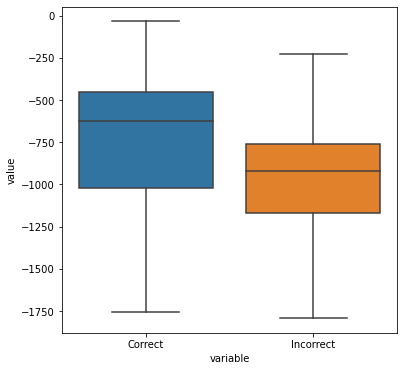

In [119]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.boxplot(x="variable", y="value", data=df_m,
              showfliers=False)